<a href="https://colab.research.google.com/github/jsilryan/Algorithms/blob/master/Handwritten_Digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor(),
    download = True
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4594060.64it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 133864.17it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:02<00:00, 635071.05it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4250452.65it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
train_data.data.shape # .size()

torch.Size([60000, 28, 28])

In [6]:
train_data.targets.size()

torch.Size([60000])

In [7]:
from torch.utils.data import DataLoader

loaders = {
    'train' : DataLoader (
        train_data,
        batch_size = 100,
        shuffle = True,
        num_workers = 1
    ),

    'test' : DataLoader (
        test_data,
        batch_size = 100,
        shuffle = True,
        num_workers = 1
    )
}

In [8]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7c1e93ee5540>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7c1e93ee44f0>}

In [9]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
    self.conv2_dropout = nn.Dropout2d() # Regularlization layer - Based on probability it randomly deactivates certain nodes in the network
    # Fully connected layer -> Linear
    self.fc1 = nn.Linear(320, 50) # 320 -> 20 (Hidden Layers from Conv2) * 4 * 4 (4 are convolutions)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_dropout(self.conv2(x)), 2))
    x = x.view(-1, 320) # Reshapes the data for linear layer -> Flattens
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training = self.training)
    x = self.fc2(x)

    return F.softmax(x) # Returns probability of each number


In [10]:
model = CNN().to(device)

optimizer = torch.optim.Adam(
    params = model.parameters(),
    lr = 0.001
  )

loss_fn = nn.CrossEntropyLoss()

In [11]:
def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(loaders['train']):
    data, target = data.to(device), target.to(device)

    # 1. Forward Pass
    prediction = model(data)

    # 2. Calculate the Loss
    loss = loss_fn(prediction, target)

    # 3. Zero_Grad
    optimizer.zero_grad()

    # 4. Loss Backward
    loss.backward()

    # 5. Optimizer Step
    optimizer.step()

    if batch_idx % 20 == 0:
      print(f"Train Epoch: {epoch} [{batch_idx * len(data)} / {len(loaders['train'].dataset)} ({100. * batch_idx / len(loaders['train']) :.0f}%)]\tLoss: {loss.item() :.6f}")

def test():
  model.eval()

  test_loss = 0
  correct = 0

  with torch.inference_mode():
    for data, target in loaders['test']:
      data, target = data.to(device), target.to(device)

      # 1. Forward Pass
      output = model(data)

      # 2. Calculate the loss
      test_loss += loss_fn(output, target).item()

      # 3. Accuracy
      test_pred = output.argmax(dim = 1, keepdim = True)
      correct += test_pred.eq(target.view_as(test_pred)).sum().item()

  test_loss /= len(loaders['test'].dataset)
  print(f"\nTest set -> Average loss: {test_loss:.4f} | Accuracy {correct} / {len(loaders['test'].dataset)} ({100. * correct / len(loaders['test'].dataset):.0f})%\n")


In [12]:
epochs = 10
for epoch in range(epochs):
  train(epoch)
  test()

<ipython-input-9-57077a1fc1fa>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x) # Returns probability of each number


Train Epoch: 0 [0 / 60000 (0%)]	Loss: 2.302442
Train Epoch: 0 [2000 / 60000 (3%)]	Loss: 2.281388
Train Epoch: 0 [4000 / 60000 (7%)]	Loss: 2.119477
Train Epoch: 0 [6000 / 60000 (10%)]	Loss: 2.000457
Train Epoch: 0 [8000 / 60000 (13%)]	Loss: 1.887352
Train Epoch: 0 [10000 / 60000 (17%)]	Loss: 1.887102
Train Epoch: 0 [12000 / 60000 (20%)]	Loss: 1.822305
Train Epoch: 0 [14000 / 60000 (23%)]	Loss: 1.755247
Train Epoch: 0 [16000 / 60000 (27%)]	Loss: 1.765471
Train Epoch: 0 [18000 / 60000 (30%)]	Loss: 1.702966
Train Epoch: 0 [20000 / 60000 (33%)]	Loss: 1.786553
Train Epoch: 0 [22000 / 60000 (37%)]	Loss: 1.699498
Train Epoch: 0 [24000 / 60000 (40%)]	Loss: 1.678521
Train Epoch: 0 [26000 / 60000 (43%)]	Loss: 1.679915
Train Epoch: 0 [28000 / 60000 (47%)]	Loss: 1.612811
Train Epoch: 0 [30000 / 60000 (50%)]	Loss: 1.643028
Train Epoch: 0 [32000 / 60000 (53%)]	Loss: 1.625650
Train Epoch: 0 [34000 / 60000 (57%)]	Loss: 1.661282
Train Epoch: 0 [36000 / 60000 (60%)]	Loss: 1.607840
Train Epoch: 0 [38000 /

torch.Size([1, 28, 28])


torch.Size([1, 1, 28, 28])


Prediction: 7


<ipython-input-9-57077a1fc1fa>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x) # Returns probability of each number


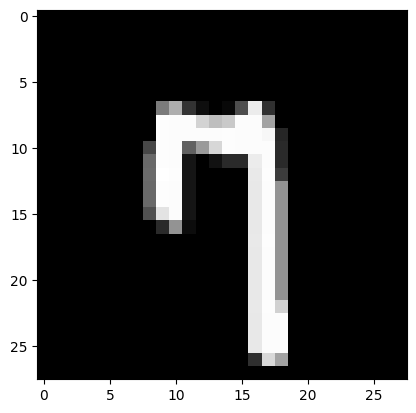

In [13]:
import matplotlib.pyplot as plt

model.eval()

data, target = test_data[80]

print(data.size())
print("\n")

data = data.unsqueeze(0).to(device)

print(data.size())
print("\n")

output = model(data)

prediction = output.argmax(dim = 1, keepdim = True).item()

print(f"Prediction: {prediction}")

# Unpack the image from the data, squeeze out channel dimension
image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap = "gray")

plt.show()

In [14]:
custom_image_path = "2.jpeg"
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(28, 28))
])

NameError: name 'transforms' is not defined

In [ ]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

custom_image = custom_image / 255

# Convert to grayscale by averaging the color channels (assuming a color image)
if custom_image.shape[0] == 3:
    custom_image = custom_image.mean(dim=0, keepdim=True)

custom_image = custom_image_transform(custom_image)

print(custom_image.size())
print("\n")

model.to(device)

model.eval()
with torch.inference_mode():
  custom_image = custom_image.unsqueeze(0)

  output = model(custom_image.to(device))

  prediction = output.argmax(dim = 1, keepdim = True).item()

  print(f"Prediction: {prediction}")

  # Unpack the image from the data, squeeze out channel dimension
  image = custom_image.squeeze(0).squeeze(0).cpu().numpy()

  plt.imshow(image)

  plt.show()